In [41]:

####################################################################################################
####################################################################################################

import sys
import os

import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from IPython.display import display

import keras
from keras import backend as K
from keras import layers
from keras.layers import Dense
from keras.models import load_model
from keras.models import Sequential
import keras.utils.vis_utils
from keras.utils import plot_model

sys.path.append(os.path.abspath("../python_pax_reader"))
import waveformset as wfset

plt.style.use('dbarge')


In [42]:

####################################################################################################
####################################################################################################

file_raw   = "../data_xenon_waveform/FakeWaveform_raw/XENON1T-0-000000000-000000999-000001000.zip"
file_truth = "../data_xenon_waveform/FakeWaveform_truth.csv"



In [43]:

####################################################################################################
####################################################################################################

nEventsGeant = 2

wfs = wfset.WaveformSet()

wfs.read_data_and_truth(file_raw, file_truth, nEventsGeant)



100%|██████████| 1000/1000 [00:03<00:00, 323.62it/s]


Events:    2
PMT Shape: (248,)


In [44]:

##########################################################################################
##########################################################################################

nEvent = 1


In [45]:

##########################################################################################
# True Time Window of S2 Pulse
##########################################################################################

df_truth = wfs.truth()[nEvent]
df_truth = df_truth.loc[df_truth['peak_type'] == 's2']

t0 = df_truth.iloc[0]['t_first_electron']
t1 = df_truth.iloc[0]['t_last_electron']

s0 = int(np.round(t0 / 10))
s1 = int(np.round(t1 / 10))

eps = (s1 - s0)*2.0
x0  = s0 - eps
x1  = s1 + eps



In [46]:

##########################################################################################
##########################################################################################

sum_waveforms = wfs.waveforms_in_channels[nEvent].drop("event_number", axis=1).iloc[:, 0:127].sum(axis=1).as_matrix()

sum_s2_all = np.sum(sum_waveforms[s0:s1])



In [47]:

##########################################################################################
##########################################################################################

df_pmts = wfs.get_waveforms_in_channels(1)

s2_sum_max = 0
s2_sum_idx = -1

for i in range(0, 127):

    col = "channel_" + str(i)
    
    arr_pmt = df_pmts[:][col].as_matrix()

    s2_sum = np.sum(arr_pmt[s0:s1])
    
    if (s2_sum > s2_sum_max):
        
        s2_sum_max = s2_sum
        s2_sum_idx = i
        
    #print("PMT " + str(i) + ": " + str(s2_sum) )
    
    continue
    


In [48]:

df_pmts = wfs.get_waveforms_in_channels(1)


##########################################################################################
##########################################################################################


arr_s2_sum = np.zeros(0)
arr_s2_idx = np.zeros(0)

for i in range(0, 127):

    col = "channel_" + str(i)
    
    arr_pmt = df_pmts[:][col].as_matrix()

    s2_sum = np.sum(arr_pmt[s0:s1])

    arr_s2_sum = np.append(arr_s2_sum, s2_sum)
    arr_s2_idx = np.append(arr_s2_idx, int(i))

    continue
    
    
##########################################################################################
##########################################################################################

df_s2_sum = pd.DataFrame(data={'s2_sum': arr_s2_sum, 'pmt': arr_s2_idx})
df_s2_sum = df_s2_sum.sort_values(['s2_sum'], ascending=False)
df_s2_sum = df_s2_sum.reset_index(drop=True)




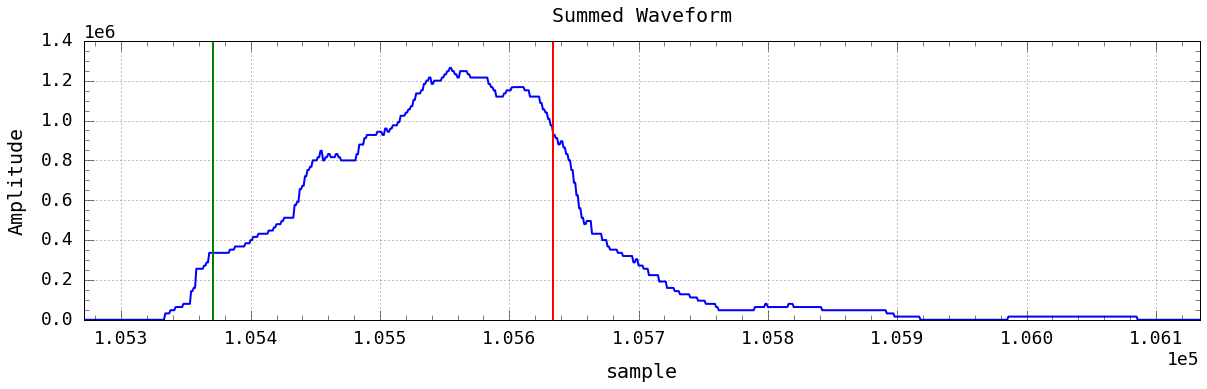

In [67]:

##########################################################################################
##########################################################################################

f  = plt.figure(figsize=(20,5))
ax = plt.plot(sum_waveforms, color='b', label='S2 Waveform summed over 127 top PMTs')

plt.xlim([s0-100, s1+500])
plt.axvline(x=s0, color='g', label='t_first_electron (truth)')
plt.axvline(x=s1, color='r', label='t_last_electron  (truth)')
plt.xlabel('sample')
plt.ylabel('Amplitude')
plt.title('Summed Waveform', y=1.05)
plt.ticklabel_format(axis='x', style='sci', scilimits=(0, 1), useOffset=False)
plt.ticklabel_format(axis='y', style='sci', scilimits=(0, 1), useOffset=False)

plt.savefig("plots/s2_waveform_window.png")

plt.close()

print()
display(f)
print()


In [ ]:
    
##########################################################################################
##########################################################################################

arr_s2_idx = df_s2_sum.iloc[:, 0].as_matrix()
arr_s2_sum = df_s2_sum.iloc[:, 1].as_matrix()
arr_s2_sum = arr_s2_sum.reshape(arr_s2_sum.size, 1)
arr_s2_denom = sum_s2_all*np.ones(arr_s2_sum.size).reshape(arr_s2_sum.size, 1)
arr_s2_frac = np.divide(arr_s2_sum, arr_s2_denom)

    
##########################################################################################
##########################################################################################

fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(20, 10))
plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.2, hspace=0.5)

ax1 = plt.subplot(2, 1, 1)
plt.plot(arr_s2_sum)
plt.xlim([0, 127])
plt.xlabel('PMT index ordered by descending fraction of total S2 integral', fontsize=20)
plt.ylabel('S2 Integral', fontsize=20)
plt.title('S2 Integral vs. PMT', fontsize=20)
plt.grid(True)

ax2 = plt.subplot(2, 1, 2)
plt.plot(arr_s2_frac)
plt.xlim([0, 127])
plt.xlabel('PMT index ordered by descending fraction of total S2 integral', fontsize=20)
plt.ylabel('S2 Integral Fraction', fontsize=20)
plt.title('S2 Integral Fraction vs. PMT', fontsize=20)
plt.grid(True)

fig.savefig("plots/s2_integral_vs_pmt.png")

In [ ]:

##########################################################################################
##########################################################################################

def test(df_s2_sum, df_pmts, nMax):

    nSamples          = len(df_pmts.index)
    arr_s2_sum_select = np.zeros(nSamples)
    s2_idxs           = df_s2_sum.iloc[0:nMax, 0:1].as_matrix().reshape(nMax)
    
    for i in range(0, nMax):
        
        idx = int(s2_idxs[i])
        s2  = arr_s2_sum_select[idx]
        
        col = "channel_" + str(idx)
        
        #print(col)
        
        arr_pmt = df_pmts[:][col].as_matrix()
    
        ##print(np.max(arr_pmt))
        
        arr_s2_sum_select = np.add(arr_s2_sum_select, arr_pmt)
        
        continue

    return arr_s2_sum_select

##########################################################################################
##########################################################################################

x_127 = test(df_s2_sum, df_pmts, 127)
x_65  = test(df_s2_sum, df_pmts,  65)
x_50  = test(df_s2_sum, df_pmts,  50)
x_30  = test(df_s2_sum, df_pmts,  30)
x_20  = test(df_s2_sum, df_pmts,  20)
x_10  = test(df_s2_sum, df_pmts,  10)



f = plt.figure(figsize=(20, 10))

plt.plot(x_127, label='S2 summed over 127 PMTs')
plt.plot(x_65 , label='S2 summed over  65 PMTs')
plt.plot(x_50 , label='S2 summed over  50 PMTs')
plt.plot(x_30 , label='S2 summed over  30 PMTs')
plt.plot(x_20 , label='S2 summed over  20 PMTs')
plt.plot(x_10 , label='S2 summed over  10 PMTs')

plt.axvline(x=s0, color='k')
plt.axvline(x=s1, color='k')

plt.xlim([s0-100, s1+300])
plt.legend(fontsize=20)

f.savefig("plots/s2_summed_frac.png")


In [ ]:

##########################################################################################
##########################################################################################

nMax = 50

arr_s2_sum_select = np.zeros(sum_waveforms.size)

s2_idxs = df_s2_sum.iloc[0:nMax, 0:1].as_matrix().reshape(nMax)

#display(df_s2_sum.iloc[0:nMax, 0:1])

#s2_idxs = int(s2_idxs)

for i in range(0, nMax):
    
    idx = int(s2_idxs[i])
    
    col = "channel_" + str(idx)
    
    #print(col)
    
    arr_pmt = df_pmts[:][col].as_matrix()

    #print(np.max(arr_pmt))
    
    arr_s2_sum_select = np.add(arr_s2_sum_select, arr_pmt)
    
    continue

    
##########################################################################################
##########################################################################################

plt.plot(sum_waveforms    , color='b')
plt.plot(arr_s2_sum_select, color='y')
plt.axvline(x=s0, color='r')
plt.axvline(x=s1, color='r')

plt.xlim([x0, x1])


In [ ]:

##########################################################################################
##########################################################################################

sum_test = np.zeros(sum_waveforms.size)

for i in range(0, 127):

    col = "channel_" + str(i)
    
    arr_pmt = df_pmts[:][col].as_matrix()
    
    #print(arr_pmt.shape)
    
    sum_test = np.add(sum_test, arr_pmt)
    
plt.plot(sum_test)



In [ ]:

##########################################################################################
##########################################################################################

fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(20, 10))
plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.2, hspace=0.5)

ax1 = plt.subplot(2, 1, 1)
plt.xlim([x0, x1])
plt.plot(sum_waveforms, color='b')
plt.plot(sum_test     , color='y')

plt.plot(df_pmt_max.as_matrix(), color='r')
plt.axvline(x=s0, color='g')
plt.axvline(x=s1, color='g')
plt.xlabel('sample')
plt.ylabel('Amplitude')
plt.title('Summed Waveform')
plt.grid(True)
y0, y1 = ax1.get_ylim()

plt.subplot(2, 1, 2)
plt.xlim([x0, x1])
#plt.ylim([y0, y1])
plt.plot(df_pmt_max.as_matrix())
plt.axvline(x=s0, color='g')
plt.axvline(x=s1, color='g')
plt.xlabel('sample')
plt.ylabel('Amplitude')
plt.title('Single PMT Waveform')
plt.grid(True)



In [ ]:

##########################################################################################
##########################################################################################

fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(10, 5))
plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.2, hspace=0.5)

plt.subplot(2, 1, 1)
plt.plot(sum_waveforms)
plt.axvline(x=s0, color='r')
plt.axvline(x=s1, color='r')

plt.xlabel('sample')
plt.ylabel('Amplitude')
plt.title('Summed Waveform')
plt.grid(True)

plt.subplot(2, 1, 2)
#plt.plot(sum_waveforms)
plt.axvline(x=s0, color='r')
plt.axvline(x=s1, color='r')
plt.xlabel('sample')
plt.ylabel('Amplitude')
plt.title('Single PMT Waveform')
plt.grid(True)


In [ ]:

####################################################################################################
####################################################################################################

print(df_train_input.shape)

arr_sums = np.zeros(0)
arr_idxs = np.zeros(0)

for i in range(0, df_train_input.shape[0]):
    
        df = df_train_input[i:i+1][:]
        
        df_sum = np.sum(df.as_matrix())
        
        arr_sums = np.append(arr_sums, df_sum)
        arr_idxs = np.append(arr_idxs, i)
        
        
        
arr_sums = np.sort(arr_sums)[::-1]

#print(arr_sums)

In [ ]:

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
sns.set(style="white", rc={"axes.facecolor": (0, 0, 0, 0)})

# Create the data
rs = np.random.RandomState(1979)
x = rs.randn(500)
g = np.tile(list("ABCDEFGHIJ"), 50)
df = pd.DataFrame(dict(x=x, g=g))
m = df.g.map(ord)
df["x"] += m

# Initialize the FacetGrid object
pal = sns.cubehelix_palette(10, rot=-.25, light=.7)
g = sns.FacetGrid(df, row="g", hue="g", aspect=15, size=.5, palette=pal)

# Draw the densities in a few steps
g.map(sns.kdeplot, "x", clip_on=False, shade=True, alpha=1, lw=1.5, bw=.2)
g.map(sns.kdeplot, "x", clip_on=False, color="w", lw=2, bw=.2)
g.map(plt.axhline, y=0, lw=2, clip_on=False)

# Define and use a simple function to label the plot in axes coordinates
def label(x, color, label):
    ax = plt.gca()
    ax.text(0, .2, label, fontweight="bold", color=color, 
            ha="left", va="center", transform=ax.transAxes)

g.map(label, "x")

# Set the subplots to overlap
g.fig.subplots_adjust(hspace=-.25)

# Remove axes details that don't play will with overlap
g.set_titles("")
g.set(yticks=[])
g.despine(bottom=True, left=True)

In [ ]:


####################################################################################################
# Create the data
####################################################################################################

x = df_train_input[0:10][:].as_matrix()
x = y.reshape(y.size)

g2 = np.tile(list("ABCDEFGHIJ"), 249)
df2 = pd.DataFrame(dict(x=x, g=g2))


####################################################################################################
# Initialize the FacetGrid object
####################################################################################################

pal2 = sns.cubehelix_palette(249, rot=-.25, light=.7)
#g2 = sns.FacetGrid(df2, row="g", hue="g", aspect=15, size=.5, palette=pal2)
g2 = sns.FacetGrid(df2, row="g", hue="g", aspect=10, palette=pal2)


####################################################################################################
# Draw the densities in a few steps
####################################################################################################

sns.set(style="white", rc={"axes.facecolor": (0, 0, 0, 0)})

g2.map(sns.kdeplot, "x", clip_on=False, shade=True, alpha=1, lw=1.5, bw=.2)
g2.map(sns.kdeplot, "x", clip_on=False, color="w", lw=2, bw=.2)
g2.map(plt.axhline, y=0, lw=2, clip_on=False)


####################################################################################################
# Define and use a simple function to label the plot in axes coordinates
####################################################################################################

def label(x, color, label):
    
    ax = plt.gca()
    ax.text(0, .2, label, fontweight="bold", color=color, ha="left", va="center", transform=ax.transAxes)

#g.map(label, "x")


####################################################################################################
####################################################################################################

g2.fig.subplots_adjust(hspace=-.25) # Set the subplots to overlap
g2.set_titles("")                   # Remove axes details that don't play will with overlap
g2.set(yticks=[])
g2.despine(bottom=True, left=True)
